In [13]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.ticker as mticker
%matplotlib inline

import numpy as np
import pandas as pd

In [76]:
path = 'lama/'
finetune = pd.read_csv(path + "edit_success_20210527.16.05.1622157123_bart-base_epoch0_ts40000.2021-05-26_10-49-10-193575oIaiD")
mmtm = pd.read_csv(path + "edit_success_mmtm0.0005_20210527.11.05.1622141346_bart-base_epoch0_ts50000.2021-05-26_10-49-10-193575oIaiD")
enn1a = pd.read_csv(path + "edit_success_20210527.13.05.1622146158_bart-base_cloze_lama_epoch0_ts40000.2021-05-24_20-21-05-594534OozFN")
# enn1b = pd.read_csv(path + "edit_success_20210525.12.05.1621972499_bart-base_cloze_lama_epoch0_ts40000.2021-05-24_20-22-06-032574KMDAu")
senn1a = pd.read_csv(path + "edit_success_20210527.15.05.1622154200_bart-base_cloze_lama_split_epoch0_ts40000.2021-05-24_20-21-36-151965uTkCl")
senn5a = pd.read_csv(path + "edit_success_20210527.15.05.1622154279_bart-base_cloze_lama_split_epoch0_ts30000.2021-05-24_21-24-00-204291diZRJ")
# senn1b = pd.read_csv(path + "edit_success_20210527.15.05.1622154157_bart-base_cloze_lama_split_epoch0_ts40000.2021-05-24_21-16-25-618252jVDEB")

In [77]:
data = [
    {"data": finetune, "opts": {"label": "BART-base", "color": "black", "linewidth": 3} },
    {"data": enn1a, "opts": { "label": "ENN-1", "color": "gray", "linewidth": 3} },  # 0.01/1
#    {"data": enn1b, "opts": { "label": "ENN-1 0.1/1", "color": "gray", "linewidth": 3} },
    {"data": senn1a, "opts": { "label": "PGP-1", "color": "red", "linewidth": 3} },  #  0.01/1
#     {"data": senn1b, "opts": { "label": "PGP-1 1/10", "color": "yellow", "linewidth": 3} },
    {"data": senn5a, "opts": { "label": "PGP-5", "color": "blue", "linewidth": 3} },  # 1/10 @30k
    {"data": mmtm, "opts": { "label": "MMTM", "color": "green", "linewidth": 3} }  # 5e-4
]


In [78]:
spacing = 10
spacing_function = lambda x: int(x /spacing + 1) * spacing
n_vis = 100

for d in data:
    d["data"]['grouping'] = d["data"].edit_number.apply(spacing_function)

In [79]:
# Plot config
# print(matplotlib.rcParams.keys())
matplotlib.rcParams["axes.titlesize"] = 20
matplotlib.rcParams["axes.labelsize"] = 16
matplotlib.rcParams["legend.fontsize"] = 14

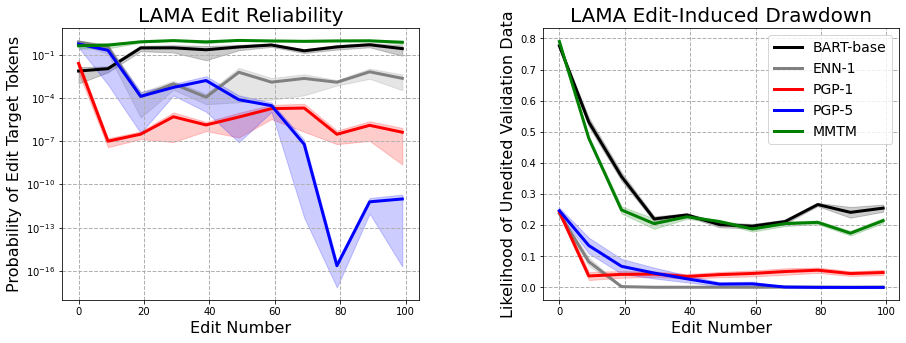

In [80]:
mean_exp = lambda x: np.mean(np.exp(x))
sem_exp = lambda x: np.exp(x).std() / x.shape[0]**0.5
def edit_metrics(frame):
    filter_query = f'edit_step == {frame.edit_step.max()} and edit_number < {n_vis} and (edit_number % 10 == 9 or edit_number == 0)'
    return (
        frame.query(filter_query).groupby("edit_number").logits.apply(mean_exp),
        frame.query(filter_query).groupby("edit_number").logits.apply(sem_exp)
    )

def drawdown_metrics(frame):
    return (
        frame.loc[~frame.new_lp.isna()].groupby("edit_number").new_lp.apply(mean_exp),
        frame.loc[~frame.new_lp.isna()].groupby("edit_number").new_lp.apply(sem_exp)
    )

fig, ax = plt.subplots(1,2,figsize=(15,5))
for d in data:
    mean, sem = edit_metrics(d["data"])
    ax[0].plot(mean, **d["opts"])
    ax[0].fill_between(mean.index, mean-sem, mean+sem, color=d["opts"]["color"], alpha=0.2)

    mean, sem = drawdown_metrics(d["data"])
    ax[1].plot(mean, **d["opts"])
    ax[1].fill_between(mean.index, mean-sem, mean+sem, color=d["opts"]["color"], alpha=0.2)

ax[0].set_title("LAMA Edit Reliability")
ax[0].set_ylabel("Probability of Edit Target Tokens")
ax[0].set_xlabel("Edit Number")

ax[1].set_title("LAMA Edit-Induced Drawdown")
ax[1].set_ylabel("Likelihood of Unedited Validation Data")
ax[1].set_xlabel("Edit Number")


ax[0].set_yscale("log")
# ax[1].set_yscale("log")
# ax[0].set_ylim(bottom=10e-7)


ax[1].legend()
ax[0].grid(linestyle="--", linewidth=1)
ax[1].grid(linestyle="--", linewidth=1)
plt.subplots_adjust(wspace=0.35)

plt.savefig('lama.pdf')